# 一维卡尔曼滤波器

In [1]:
%matplotlib inline

import lean.book_format as book_format
book_format.set_style()

现在我们了解了离散贝叶斯滤波器和高斯，我们准备实现卡尔曼滤波器。我们将完全按照离散贝叶斯滤波器的方式执行此操作,而不是从方程开始，我们将根据对问题的推理逐步开发代码。

“一维”表示滤波器仅跟踪一个状态变量，例如 x 轴上的位置。在随后的章节中，我们将学习一种更通用的多维滤波器形式，它可以同时跟踪许多状态变量，例如位置、速度和加速度。回想一下，我们在g-h滤波器中使用速度来获得比单独跟踪位置更好的估计值。卡尔曼滤波器也是如此。

那么，为什么不直接跳入滤波器的多维形式呢？老实说，数学很困难，我开发滤波器的直观方法开始崩溃。这种数学模糊了允许卡尔曼滤波器工作的相当简单的原理。

因此，在本章中，我们将学习如何使用高斯来实现贝叶斯滤波器。这就是卡尔曼滤波器的全部内容 - 使用高斯的贝叶斯滤波器。在下一章中，我们将切换到多维形式，卡尔曼滤波器的全部力量将被释放！

## 一、问题描述



与离散贝叶斯滤波器一章一样，我们工作中，将在一个常常走廊里跟踪一个移动物体。假设在我们最新的黑客马拉松中，有人创建了一个RFID跟踪器，可以提供相当准确的狗的位置。传感器返回狗与走廊左端的距离（以米为单位）。因此，23.4 意味着狗距离走廊左端 23.4 米。

传感器并不完美。读数为 23.4 可能对应于狗在 23.7 或 23.0。但是，它不太可能对应于47.6的位置。黑客马拉松期间的测试证实了这一结果 - 传感器“合理”准确，虽然它有错误，但错误很小。此外，误差似乎均匀分布在真实位置的两侧;23 m 的位置同样可能被测量为 22.9 或 23.1。也许我们可以用高斯模型来建模。

我们预测狗正在移动。这个预测并不完美。有时我们的预测会超调，有时会低于。我们更有可能低于或超过一点点而不是很多。也许我们也可以用高斯来建模。

## 二、高斯信念

我们可以用高斯来表达我们对狗的位置的信念。假设我们相信我们的狗在 10 米处，并且该信念的方差为1 m$^2$, 或者 $\mathcal{N}(10,\, 1)$。概率密度PDF图如下：


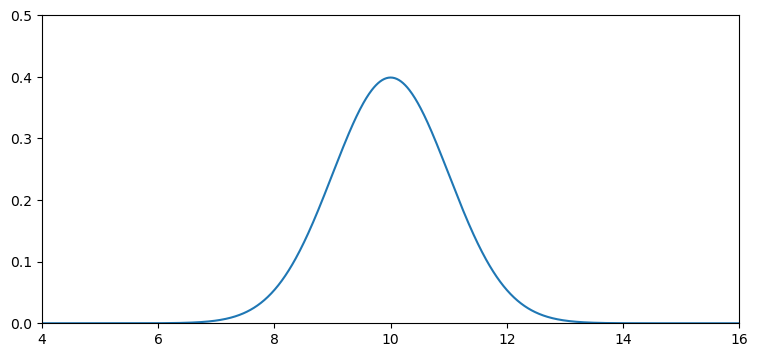

In [2]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));

这个图描绘了我们对狗的位置的不确定性。它代表了一种相当不准确的信念。虽然我们认为狗最有可能在 10 m 处，但 9 m 到 11 m 左右的任何位置也很有可能。假设狗站着不动，我们再次查询传感器。这次它返回 10.2 m。我们可以使用这些额外的信息来改进我们的估计吗？

直觉表明我们可以。考虑一下：如果我们读取传感器 500 次，每次它返回一个介于 8 和 12 之间的值，都以 10 为中心，我们应该非常确信狗接近 10。当然，可以有不同的解释。也许我们的狗以一种完全模拟正态分布随机抽取的方式随机来回徘徊。但这似乎极不可能——我从未见过狗这样做。让我们看看做500次实验，基于$\mathcal N(10, 1)$：



Mean of readings is 9.940


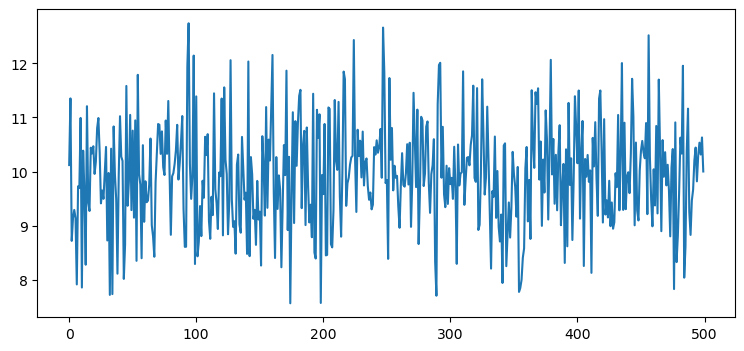

In [3]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

目测这证实了我们的直觉——没有狗像这样移动。然而，嘈杂的传感器数据肯定是这样的。读数的计算平均值几乎正好是 10。假设狗站着不动，我们说狗在位置 10，方差为 1。

## 三、使用高斯概率进行跟踪

离散贝叶斯滤波器使用概率直方图来跟踪狗。直方图中的每个箱代表一个位置，它的值是狗处于该位置的概率。

跟踪是通过预测和更新的周期执行计算的。我们使用了方程式：

$$\begin{aligned} 
\bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict} \\
\mathbf x &= \mathcal L \cdot \bar{\mathbf x}\, \, &\text{Update}
\end{aligned}$$

去计算新的概率分布。回想一下 $\bar{\mathbf x}$ 是 *先验*, $\mathcal L$ 是给定先验$\bar{\mathbf x}$情况下的测量*可能性*, $f_{\mathbf x}(\bullet)$ 是 *过程模型*, $\ast$ 表示 *卷积*. $\mathbf x$ 以粗体表示它是数字的直方图或向量。

这种方法有效，但是直方图显示狗可能同时在多个地方。此外，对于大型问题，计算速度非常慢。

我们可以用高斯 $\mathcal N(\mu, \sigma^2),$替换直方图 $\mathbf x$ 吗？绝对！我们已经学会了如何表达高斯信念。高斯，它就是单个数字对 $\mathcal N(\mu, \sigma^2),$ 可以替换整个概率直方图：


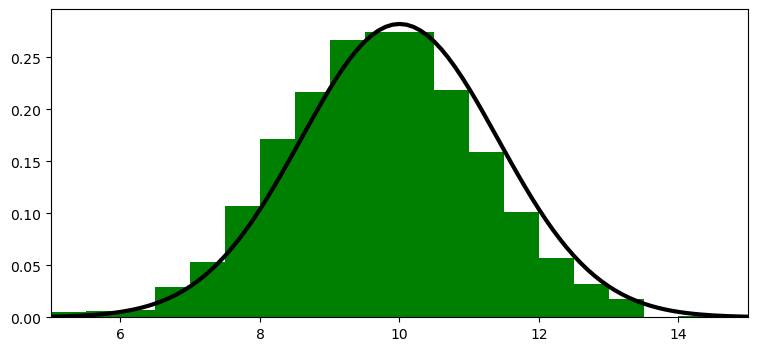

In [4]:
import lean.kf_book.kf_internal as kf_internal
kf_internal.gaussian_vs_histogram()

我希望你看到它的力量。我们可以用一对数字替换数百到数千个数字：$x = \mathcal N(\mu, \sigma^2)$

高斯的尾部在两侧延伸到无穷大，因此它在直方图中包含任意多个条形。如果这代表了我们对狗在走廊中位置的信念，那么这个高斯涵盖了整个走廊（以及该轴上的整个范围）。我们认为狗很可能在 10 米的位置，但他可能在 8、14 米的位置，或者，以无限小的概率，在  $10^{80}$ 米的位置。

在本章中，我们将直方图替换为高斯图：

$$\begin{array}{l|l|c}
\text{discrete Bayes} & \text{Gaussian} & \text{Step}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f(\mathbf x) & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}}(\bullet) &
\text{Predict} \\
\mathbf x = \|\mathcal L \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Update} 
\end{array}$$

其中 $\oplus$ 和 $\otimes$旨在表达高斯上的某个未知运算符。我不会在本书的其余部分这样做，但下标$x_\mathcal{N}$表明是高斯的。

离散贝叶斯滤波器使用卷积进行预测。我们证明它使用了总概率定理，计算为总和，所以也许我们可以使用高斯叠加。它使用乘法将测量值合并到先验中，所以也许我们可以乘以高斯。会不会这么简单：

$$\begin{aligned} 
\bar x &\stackrel{?}{=} x + f_x(\bullet) \\
x &\stackrel{?}{=} \mathcal L \cdot \bar x
\end{aligned}$$

这只有在两个高斯的和和乘积是另一个高斯时才有效。否则在第一个纪元之后 $x$ 就不是高斯了，这个方案就分崩离析了。



## 四、使用高斯预测

我们使用牛顿运动方程根据当前速度和先前位置计算当前位置：

$$ \begin{aligned}\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$

我已经放弃了符号 $f_x(\bullet)$，转而使用 $f_x$ 以保持方程整洁。

如果狗在 10 m 处，他的速度是 15 m/s，纪元长 2 秒，我们有

$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 2\\
\bar{x}_k &= 10 + (15\cdot 2) = 40 \end{aligned}$$

我们不确定他目前的位置和速度，所以这不行。我们需要用高斯来表达不确定性。

位置很容易。我们将  $x$ 定义为高斯。如果我们认为狗在 10 m 处，并且不确定性的标准差为 0.2 m，则得到 $x=\mathcal N(10, 0.2^2)$。

怎么描述它的运动中的不确定性呢？我们将 $f_x$ 定义为高斯。如果狗的速度是 15 m/s，epoch 是 1 秒，我们的不确定性的标准差是 0.7 m/s，我们得到 $f_x = \mathcal N (15, 0.7^2)$。

先验的方程为：

$$\bar x = x + f_x$$

两个高斯之和是多少？在最后一章中，我证明了：

$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

这是个好消息;两个高斯之和是另一个高斯！

数学有效，但这是否直观有意义？想想这个抽象方程的物理表示。我们有

$$\begin{gathered}
x=\mathcal N(10, 0.2^2)\\
f_x = \mathcal N (15, 0.7^2)
\end{gathered}$$

如果我们添加这些，我们会得到：

$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 10 + 15 &&= 25 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 &&= 0.53\end{aligned}$$

预测位置是前一个位置加上移动是有道理的。方差呢？对此很难形成直觉。但是，回想一下，使用离散贝叶斯滤波器的predict的函数，我们总是丢失信息。我们真的不知道狗在哪里移动，所以信心应该变小（方差变大）。$\sigma_{f_x}^2$ 是由于对运动的不完美预测而添加到系统中的不确定性量，因此我们将其添加到现有的不确定性中。

让我们利用 Python collection 模块中的 namedtuple 类来实现一个高斯对象.们可以使用元组实现高斯，其中$\mathcal N(10, 0.04)$在Python中被实现为`g = (10., 0.04)`。我们可以得到均值 `g[0]` 和方差 `g[1]`。

namedtuple工作原理与元组相同，只是您为其提供类型名称和字段名称。理解这一点并不重要，但我修改了该方法以使用本章中的符号显示其值。__repr__

In [5]:
from collections import namedtuple
gaussian = namedtuple("Gaussian", ["mean", "var"])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

现在我们可以创建一个高斯，并打印

In [6]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2*0.2)
print(g1)
print(g2)

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


我们可以用下标或字段名称访问均值和方差：

In [7]:
g1.mean, g1.var, g2[0], g2[1]

(3.4, 10.1, 4.5, 0.04000000000000001)

下面是我们对预测函数的实现，其中位置和运动是以高斯的形式($\mu$, $\sigma^2$)。

In [8]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

让我们测试一下。如果初始位置是高斯 $\mathcal N(10, 0.2^2)$，而运动是高斯$\mathcal N (15, 0.7^2)$ ，则先验是什么？

In [9]:
pos = gaussian(10., 0.2**2)
move = gaussian(15., 0.7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

先验指出，狗在 25 m 处，方差为 0.53 m$^2$ ，这和我们手动计算的一致。

## 五、使用高斯更新

离散贝叶斯滤波器将我们对狗位置的信念编码为概率直方图。分布是离散的和多模态的。它可以表达强烈的信念，即狗同时处于两个位置，并且位置是离散的。

我们建议用高斯图替换直方图。离散贝叶斯滤波器使用以下代码来计算后验：

```python
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```

其中，等式的实现是：

$$x = \| \mathcal L\bar x \|$$

我们刚刚证明了我们可以用高斯表示先验。可能性（likelihood）如何？可能性是给定当前状态(先验)的测量概率。我们已经学会了如何将测量值表示为高斯量。例如，也许我们的传感器指出狗在 23 m 处，标准偏差为 0.4 米。我们的测量值（以可能性表示）是 $z = \mathcal N (23, 0.16)$。

可能性和先验都是用高斯模型建模的。我们可以乘以高斯吗？两个高斯的乘积是另一个高斯吗？

前者是对的，后者几乎也是对的！在最后一章中，我证明了两个高斯的乘积与另一个高斯成正比。

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

我们可以立即推断出几件事。如果我们对结果进行归一化，则乘积是另一个高斯。如果一个高斯是可能性（likelihood），第二个高斯是先验（prior），则均值是先验和测量值的缩放和。方差是先验方差和度量方差的组合。最后，方差完全不受均值的影响！

我们用贝叶斯术语来表示，如下所示：

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&= \| \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \|\\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

如果我们在一个函数gaussian_multiply()中实现它，我们可以将滤波器的更新步骤实现为：

In [10]:
# 高斯乘法
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    var = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, var)

# 基于高斯的update操作
def update(prior, likelihood):
    posterior = gaussian_multiply(prior, likelihood)
    return posterior

# 测试高斯更新函数
predicted_pos =  gaussian(10., 0.2**2)
measured_pos = gaussian(11., 0.1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=10.800, 𝜎²=0.008)

如果我们使用更具体的名称，也许这会更清楚：

```python
def update_dog(dog_pos, measurement):
    estimated_pos = gaussian_multiply(measurement, dog_pos)
    return estimated_pos  
```

这不那么抽象，这可能有助于理解，但这是糟糕的编码实践。我们正在编写一个卡尔曼滤波器，可以解决任何问题，而不仅仅是在走廊里跟踪狗，所以我们不会使用带有“dog”的变量名称。此外，这种形式掩盖了我们将可能性（likelihood）乘以先验（prior）的事实。

我们已经实现了滤波器的大部分内容，但我担心这一步仍然有点令人困惑。我已经断言我们可以乘以高斯并且它正确地执行了更新步骤，但为什么这是正确的？让我们绕道而行，花一些时间研究高斯乘法。

## 六、了解高斯乘法

让我们绘制高斯乘法 $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$的概率密度pdf图 .你能在不看结果的情况下确定它的形状吗？新的含义应该是什么？曲线是更宽、更窄？还是与$\mathcal{N}(10,\, 1)$相同?

𝒩(μ=10.000, 𝜎²=0.500)


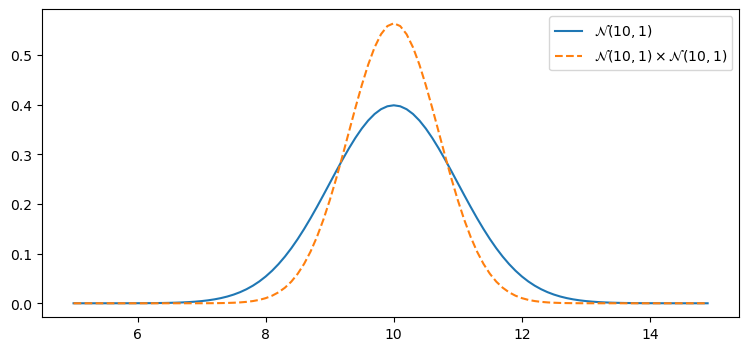

In [11]:
z = gaussian(10., 1.)
product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

乘法的结果比原始高斯更高更窄，但平均值保持不变。这符合你的直觉吗？

将高斯量视为两个测量值。如果我测量两次，每次得到 10 米，我应该得出结论，长度接近 10 米。因此，平均值应为 10。断定长度实际上是 11 或 9.5 是没有意义的。此外，我对两个测量比一个测量更有信心，因此结果的方差应该更小。

“测量两次，切割一次”（三思而后行）是一句众所周知的说法。高斯乘法是这个物理事实的数学模型。

我不太可能连续两次获得相同的测量结果。现在让我们绘制 pdf 的$\mathcal{N}(10.2,\, 1) \times \mathcal{N}(9.7,\, 1)$。你认为结果会是什么？想一想，然后看图表。

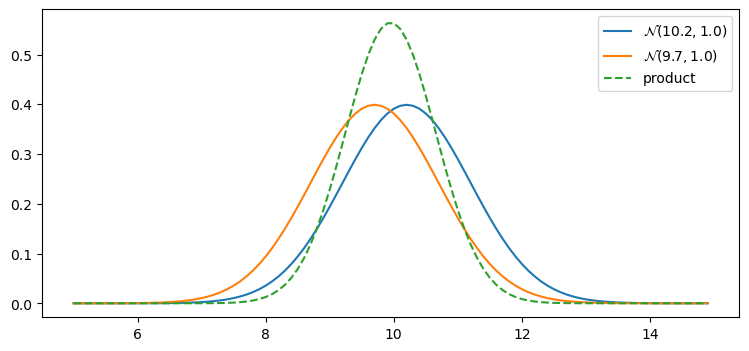

In [12]:
# 绘制高斯乘法的图像
def plot_products(g1, g2):
    plt.figure()
    product = gaussian_multiply(g1, g2)
    
    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g1.mean, g1.var))
    
    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g2.mean, g2.var))
    
    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend()
    
z1 = gaussian(10.2, 1.)
z2 = gaussian(9.7, 1.)

plot_products(z1, z2)
    

如果你让两个人测量一张桌子到墙的距离，一个人得到10.2米，另一个得到9.7米，你最好的猜测一定是平均值，如果你同样信任两者的技能，那就是9.95米。

回想一下 g-h 过滤器。我们一致认为，如果我在两个秤上称量自己，第一个读数为160磅，第二个读数为170磅，并且两者都同样准确，则最佳估计值为165磅。此外，我应该对 165 磅与 160 磅或 170 磅更有信心，因为我现在有两个读数，都接近这个估计值，增加了我对两者都不是大错特错的信心。

在更复杂的情况下，这变得违反直觉，所以让我们进一步考虑一下。也许更合理的假设是一个人犯了一个错误，真实距离是10.2或9.7，但肯定不是9.95。这当然是可能的。但我们知道我们有嘈杂的测量结果，所以我们没有理由认为其中一个测量值没有噪音，或者一个人犯了一个严重的错误，允许我们放弃他们的测量结果。鉴于所有可用信息，最佳估计值一定是 9.95。

在卡尔曼滤波器的更新步骤中，我们不合并两个测量值，而是合并一个测量值和未测量之前的先验估计值。我们根据g-h滤波器的这个逻辑。无论我们合并来自两个测量的信息，还是一个测量和一个预测，数学都是相同的。

让我们看看这个例子。我将创建一个相当不准确的先验 $\mathcal N(8.5, 1.5)$ 以及更准确的测量 $\mathcal N(10.2, 0.5).$ 我所说的“准确”是指传感器方差小于先验方差，而不是我以某种方式知道狗比 10.2 更接近 8.5。接下来，我将绘制反向关系：准确的先验 $\mathcal N(8.5, 0.5)$ 和不准确的测量$\mathcal N(10.2, 1.5)$。


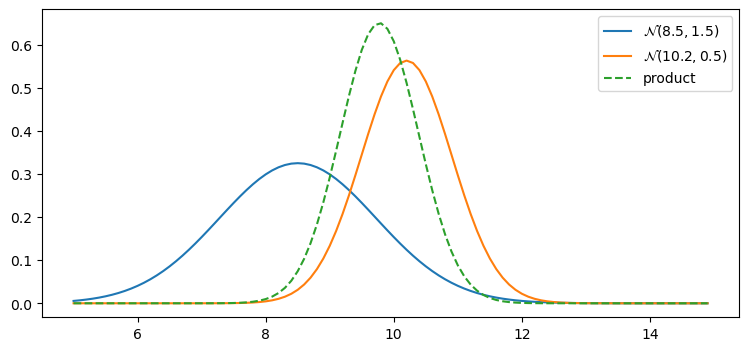

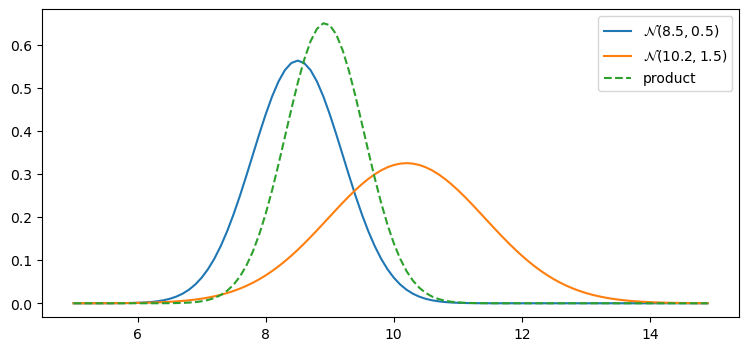

In [13]:
prior, z = gaussian(8.5, 1.5), gaussian(10.2, 0.5)
plot_products(prior, z)

prior, z = gaussian(8.5, 0.5), gaussian(10.2, 1.5)
plot_products(prior, z)

高斯乘积的结果是高于任一输入的。这是有道理的-我们已经合并了信息，因此我们的方差应该减少。请注意，结果更接近方差较小的输入。我们对这个价值（分布）更有信心，所以更重视它是有意义的。

它似乎有效，但它真的正确吗？关于这一点还有更多要说的，但我想让一个有效的滤波器运行，以便您可以具体体验它。之后，我们将重新审视高斯乘法并确定它为什么是正确的。